# PUI2017 HW6 
Rachel Lim 

In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import geopandas as gpd
import pylab as pl
import os
import json
import fiona

import statsmodels.api as sm
import statsmodels.formula.api as smf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Question: 

"can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
So let's test if the last link holds. If we have data on the energy consumed by a building how well does that relate to the number of units in the building?

### Data Source: 
https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z

In [2]:
PUIdata = os.getenv('PUIDATA')
print (PUIdata)

/home/cusp/vmr286/PUIdata


### Data: Manhattan PLUTO information

Source: https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page

Download link: https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip

This download is a zip file of the PLUTO dataset for all NYC boroughs, but for this homework, I will only use the Manhattan data.

In [3]:
if not os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
    print('Downloading...')
    os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip')
    os.system('mv nyc_pluto_16v2%20.zip ' + PUIdata)
    os.system('unzip ' + PUIdata + '/nyc_pluto_16v2%20.zip -d ' + PUIdata)
    if os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
        print('File in place, proceed!')
else:
    print('File in place, proceed!')

File in place, proceed!


### Data: LL84 Report for 2013
Source: https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z

Download link (retrieved from API): https://data.cityofnewyork.us/resource/m46j-75iy.csv

In [4]:
url = 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'
filename = 'LL84_2013.csv'

if not os.path.isfile(PUIdata + '/' + filename):
    print('Downloading...')
    os.system('wget ' + url)
    os.system('mv rows.csv?accessType=DOWNLOAD ' + filename)
    os.system('mv ' + filename + ' ' + PUIdata)
    if os.path.isfile(PUIdata + '/' + filename):
        print('File in place, proceed!')
else:
    print('File in place, proceed!')

Downloading...
File in place, proceed!


In [5]:
#specify zipfile url
dfman = pd.read_csv(PUIdata + '/BORO_zip_files_csv/MN.csv')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
dfman.columns

Index([u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'SanitBoro', u'SanitDistrict', u'SanitSub', u'Address',
       u'ZoneDist1', u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'Overlay1',
       u'Overlay2', u'SPDist1', u'SPDist2', u'SPDist3', u'LtdHeight',
       u'SplitZone', u'BldgClass', u'LandUse', u'Easements', u'OwnerType',
       u'OwnerName', u'LotArea', u'BldgArea', u'ComArea', u'ResArea',
       u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea',
       u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', u'BldgFront',
       u'BldgDepth', u'Ext', u'ProxCode', u'IrrLotCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
       u'YearBuilt', u'YearAlter1', u'YearAlter2', u'HistDist', u'Landmark',
       u'BuiltFAR', u'ResidFAR', u'CommFAR', u'

In [7]:
#cleaning data
dfman = dfman[['UnitsTotal', 'UnitsRes', 'BBL', 'YearBuilt']]

In [8]:
dfen = pd.read_csv(PUIdata + '/LL84_2013.csv')

In [9]:
dfen.columns

Index([u'Record Number', u'BBL', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract', u'BI

In [10]:
dfen = pd.read_csv(PUIdata + '/LL84_2013.csv')

In [11]:
dfeno = dfen[['BBL', 'Postcode', 'DOF Property Floor Area (Buildngs and Parking)(ft2)', 'DOF Number of Buildings', 'Site EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ft²)']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f488fba1490>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f488fd8bfd0>]], dtype=object)

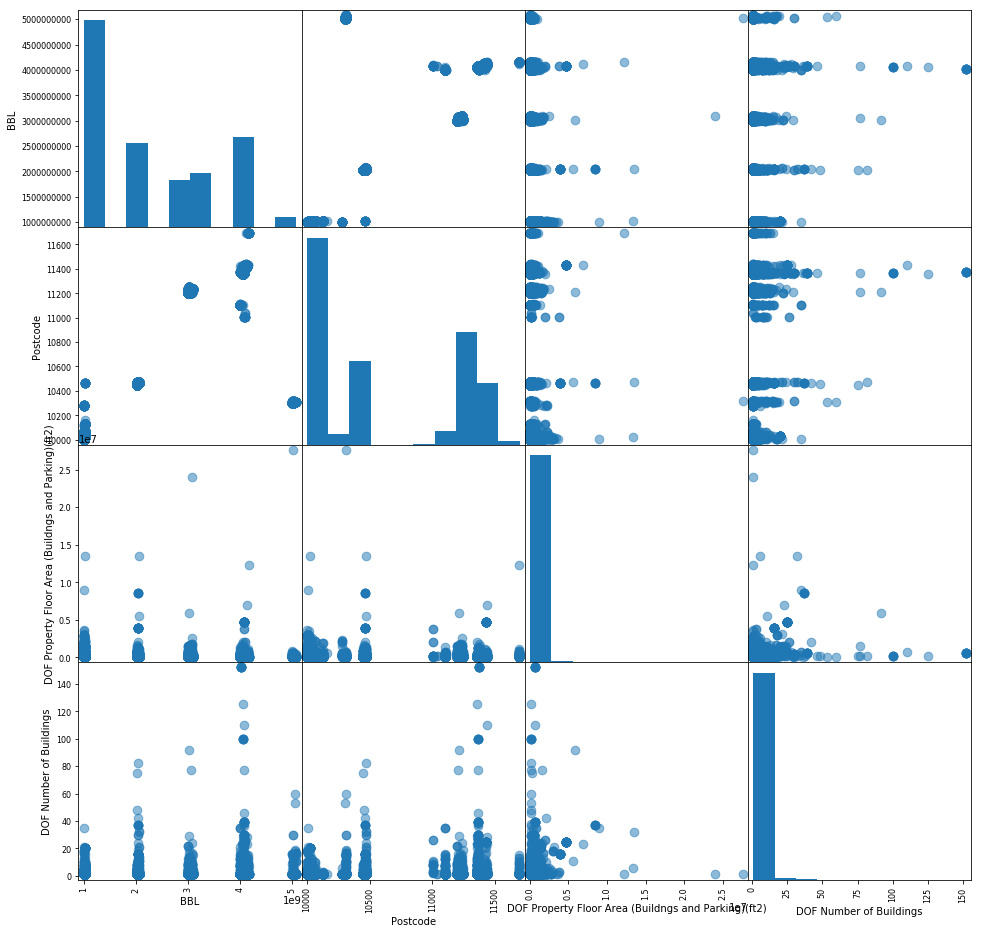

In [12]:
#generate scatter plot of dfen 
from pandas.tools.plotting import scatter_matrix
scatter_matrix(dfeno, s=300, figsize=(16,16))


Figure 1: Scatter matrix of all numerical values in the files

The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them.

In [13]:
dfen = dfen[['BBL', 'DOF Property Floor Area (Buildngs and Parking)(ft2)', 'Site EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ft²)']]

In [14]:
s = dfen['Site EUI(kBtu/ft2)'] #extract Site EUI as series
ss = pd.to_numeric(s, errors='coerce')  # convert strings to float, use errors=coerce to set missing values to nan
dfen['Site EUI(kBtu/ft2)'] = ss
##check that your conversion worked: e.g.
print (dfen['Site EUI(kBtu/ft2)'].astype(float))

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16       125.4
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
         ...  
16140      NaN
16141      NaN
16142      NaN
16143      NaN
16144      NaN
16145      NaN
16146      NaN
16147      NaN
16148      NaN
16149      NaN
16150      NaN
16151      NaN
16152      NaN
16153      NaN
16154      NaN
16155      NaN
16156      NaN
16157      NaN
16158      NaN
16159      NaN
16160      NaN
16161      NaN
16162      NaN
16163      NaN
16164      NaN
16165      NaN
16166      NaN
16167      NaN
16168      NaN
16169      NaN
Name: Site EUI(kBtu/ft2), dtype: float64


In [15]:
sman = dfman['BBL'] 
ssman = pd.to_numeric(sman, errors='coerce')
dfman['BBL'] = ssman
dfman.BBL.astype(float)
#this should not return an error
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

0        1.000010e+09
1        1.000010e+09
2        1.000010e+09
3        1.000010e+09
4        1.000010e+09
5        1.000020e+09
6        1.000020e+09
7        1.000020e+09
8        1.000020e+09
9        1.000030e+09
10       1.000030e+09
11       1.000030e+09
12       1.000030e+09
13       1.000030e+09
14       1.000048e+09
15       1.000050e+09
16       1.000058e+09
17       1.000060e+09
18       1.000070e+09
19       1.000070e+09
20       1.000070e+09
21       1.000070e+09
22       1.000070e+09
23       1.000070e+09
24       1.000070e+09
25       1.000070e+09
26       1.000070e+09
27       1.000078e+09
28       1.000078e+09
29       1.000080e+09
             ...     
42928    1.022480e+09
42929    1.022480e+09
42930    1.022480e+09
42931    1.022480e+09
42932    1.022480e+09
42933    1.022480e+09
42934    1.022480e+09
42935    1.022480e+09
42936    1.022480e+09
42937    1.022480e+09
42938    1.022488e+09
42939    1.022500e+09
42940    1.022500e+09
42941    1.022500e+09
42942    1

In [16]:
r = dfen['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'] #extract Site EUI as series
rr = pd.to_numeric(r, errors='coerce')  # convert strings to float, use errors=coerce to set missing values to nan
dfen['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'] = rr
##check that your conversion worked: e.g.
print (dfen['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'].astype(float))

0        918919.0
1             NaN
2         64200.0
3             NaN
4         50000.0
5         61800.0
6        102198.0
7         46620.0
8             NaN
9         54029.0
10            0.0
11       171502.0
12            NaN
13        68750.0
14            NaN
15            NaN
16       330000.0
17            NaN
18        69160.0
19        52974.0
20        82200.0
21        63360.0
22        52960.0
23            NaN
24            NaN
25       154754.0
26       465667.0
27            NaN
28        68329.0
29        66546.0
           ...   
16140         NaN
16141         NaN
16142         NaN
16143         NaN
16144         NaN
16145         NaN
16146         NaN
16147         NaN
16148         NaN
16149         NaN
16150         NaN
16151         NaN
16152         NaN
16153         NaN
16154         NaN
16155         NaN
16156         NaN
16157         NaN
16158         NaN
16159         NaN
16160         NaN
16161         NaN
16162         NaN
16163         NaN
16164     

In [17]:
#How many missing values?
indx = np.isnan(dfen['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

invalid entries changed to NaN 3125


### Merge the Dataset

In [18]:
(dfman.BBL.values[0]), (dfen.BBL.values[0])

(1000010010.0, 1000410001.0)

In [19]:
#merging dataset
bbljoin = dfman.merge(dfen, right_on='BBL', left_on='BBL')
bbljoin.dropna()
bbljoin.shape

(6536, 7)

In [20]:
#renaming columns
bbljoin.columns = ['UnitsTotal', 'UnitsRes', 'BBL', 'YearBuilt', 'DOFarea', 'SiteEUI', 'Reportedarea']
bbljoin.head()

UnitsTotal  UnitsRes           BBL  YearBuilt    DOFarea  SiteEUI  \
0           0         0  1.000010e+09       1900  2725731.0      NaN   
1          52         0  1.000048e+09       1969  2621563.0     92.5   
2           1         0  1.000050e+09       1969  1016406.0      NaN   
3           7         0  1.000058e+09       1970  1354691.0    134.5   
4          43        42  1.000078e+09       1920        NaN     57.8   

   Reportedarea  
0           NaN  
1     2428325.0  
2           NaN  
3     1338000.0  
4       55689.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f488fcab350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f489dae9f10>]], dtype=object)

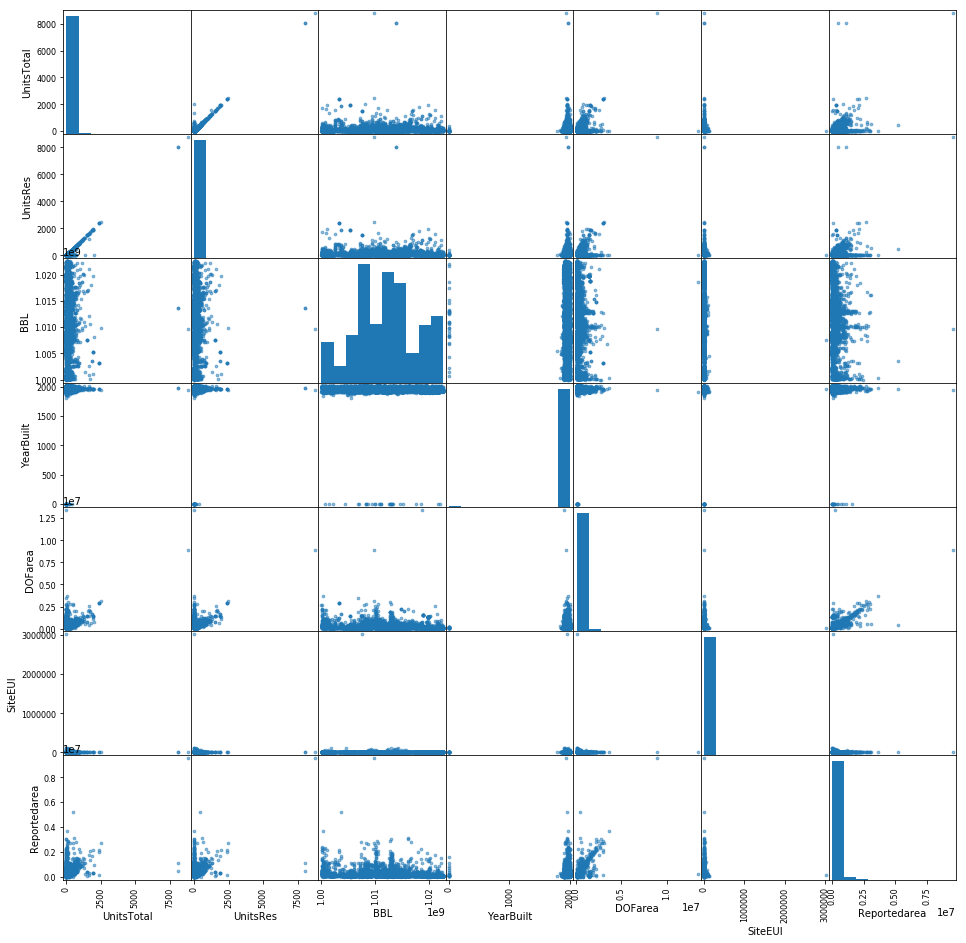

In [21]:
#plotting the scatter again
scatter_matrix(bbljoin, s=30, figsize=(16,16))

In [22]:
#calculate Energy Total
bbljoin['EnergyTotal'] = bbljoin.SiteEUI * bbljoin.Reportedarea
bbljoin.head()

UnitsTotal  UnitsRes           BBL  YearBuilt    DOFarea  SiteEUI  \
0           0         0  1.000010e+09       1900  2725731.0      NaN   
1          52         0  1.000048e+09       1969  2621563.0     92.5   
2           1         0  1.000050e+09       1969  1016406.0      NaN   
3           7         0  1.000058e+09       1970  1354691.0    134.5   
4          43        42  1.000078e+09       1920        NaN     57.8   

   Reportedarea  EnergyTotal  
0           NaN          NaN  
1     2428325.0  224620062.5  
2           NaN          NaN  
3     1338000.0  179961000.0  
4       55689.0    3218824.2

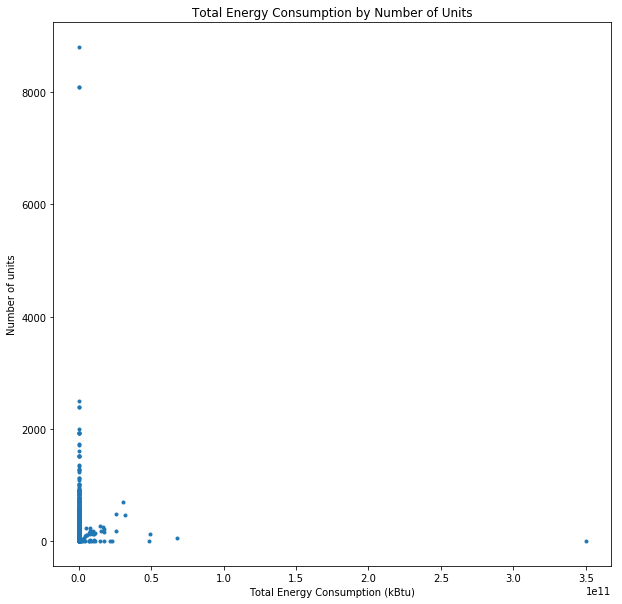

In [23]:
#first scatter plot
plt.figure(figsize=(10,10))
plt.plot(bbljoin['EnergyTotal'], bbljoin['UnitsTotal'],'.')

plt.xlabel('Total Energy Consumption (kBtu)')
plt.ylabel('Number of units')
plt.title('Total Energy Consumption by Number of Units')

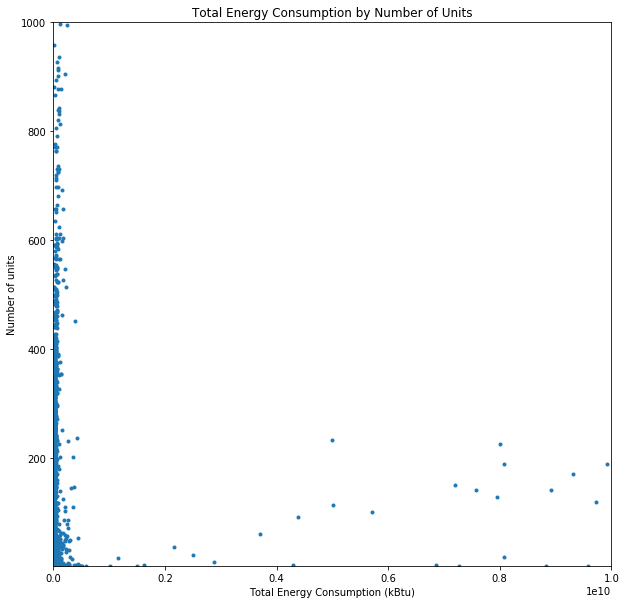

In [24]:
#second scatter plot (zoom into region with most points)
plt.figure(figsize=(10,10))
plt.plot(bbljoin['EnergyTotal'], bbljoin['UnitsTotal'],'.')
plt.xlim(1000, 1e10)
plt.ylim(1, 1000)
plt.xlabel('Total Energy Consumption (kBtu)')
plt.ylabel('Number of units')
plt.title('Total Energy Consumption by Number of Units')

In [25]:
#Try making a log plot instead 
#use keyword loglog: bbljoindata.plot(...loglog=True)
#Remove outliers in dataset to cut data (remove zeros/set a sensible threshold)
#remove zero values which may be empty lots or missing values
bbljoincut = bbljoin[(bbljoin['UnitsTotal']>10) & bbljoin['EnergyTotal']>0]

In [26]:
bbljoincut['UnitsTotal'].dropna(inplace=True)
bbljoincut['EnergyTotal'].dropna(inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/series.py:2571: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [27]:
bbljoincut.head()

UnitsTotal  UnitsRes           BBL  YearBuilt    DOFarea  SiteEUI  \
1           52         0  1.000048e+09       1969  2621563.0     92.5   
4           43        42  1.000078e+09       1920        NaN     57.8   
5           98        97  1.000088e+09       1985   169061.0    118.9   
9           15         0  1.000100e+09       1986   365792.0    106.1   
11          20         0  1.000100e+09       1962   321994.0    108.0   

    Reportedarea  EnergyTotal  
1      2428325.0  224620062.5  
4        55689.0    3218824.2  
5       169055.0   20100639.5  
9       405310.0   43003391.0  
11      329991.0   35639028.0

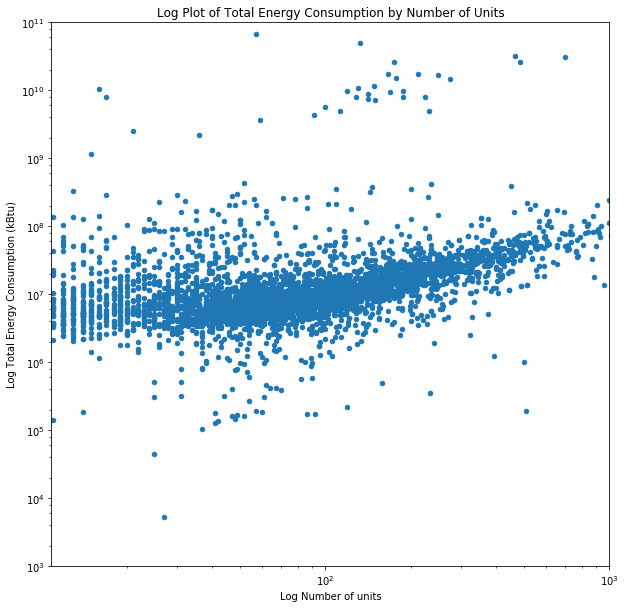

In [28]:
#log plot
bbljoincut.plot.scatter('UnitsTotal', 'EnergyTotal',
                        loglog=True, figsize=(10,10))

plt.xlim(0,1000)
plt.ylim(1000,1e11)
plt.xlabel('Log Number of units')
plt.ylabel('Log Total Energy Consumption (kBtu)')
plt.title('Log Plot of Total Energy Consumption by Number of Units')

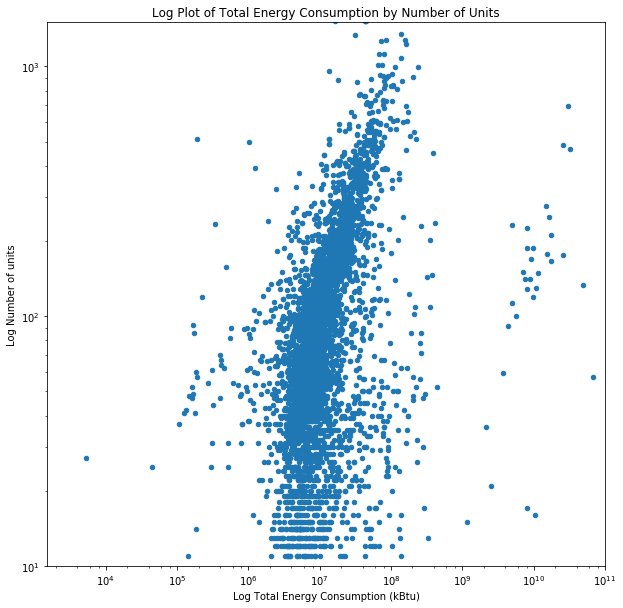

In [29]:
#log plot
bbljoincut.plot.scatter('EnergyTotal', 'UnitsTotal', 
                        loglog=True, figsize=(10,10))

plt.xlim(1500,1e11)
plt.ylim(10,1500)
plt.xlabel('Log Total Energy Consumption (kBtu)')
plt.ylabel('Log Number of units')
plt.title('Log Plot of Total Energy Consumption by Number of Units')

Energy on size on building/ size of building on energy? Fit a line to both Units vs Energy, and Energy vs Units

### Modelling: Fitting a Line

### 1. Unit Vs Energy

In [30]:
#Since we see hints of a linear relationship in the log space, we will fit a line to the log of our variables
#First fit a line to Units vs Energy
#independent: UnitsTotal, dependent: EnergyTotal
x = bbljoincut['UnitsTotal']
y = bbljoincut['EnergyTotal']
x = sm.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), x, missing='drop').fit() #ignore entries where x or y is nan
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            EnergyTotal   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     901.5
Date:                Mon, 04 Dec 2017   Prob (F-statistic):          6.76e-180
Time:                        12:24:51   Log-Likelihood:                -2599.7
No. Observations:                4280   AIC:                             5203.
Df Residuals:                    4278   BIC:                             5216.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.0860      0.032    187.617      0.000         6.022     6.150
UnitsTotal     0.5011      0.017     30.025      0.000         0.468     0.534
==============================================================================
Omnibus:                     2256.573   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44258.738
Skew:                           2.072   Prob(JB):                         0.00
Kurtosis:                      18.199   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

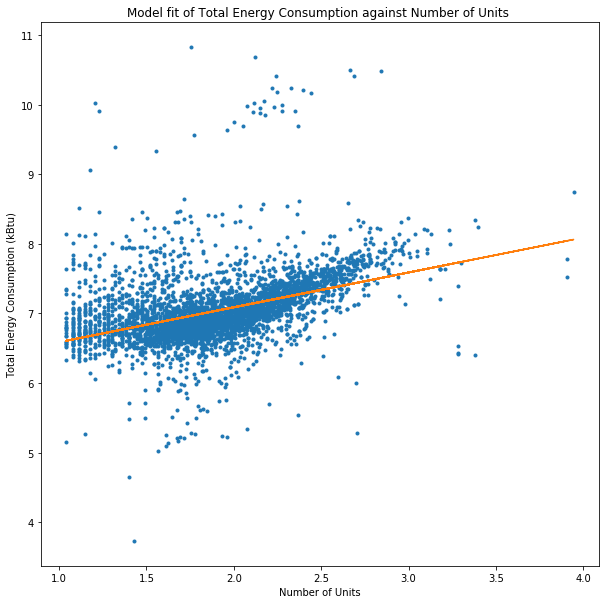

In [31]:
plt.figure(figsize=(10,10))
plt.plot(np.log10(bbljoincut['UnitsTotal']), 
         np.log10(bbljoincut['EnergyTotal']), '.')

plt.plot(np.log10(bbljoincut['UnitsTotal']), 
         linmodel.predict(sm.add_constant(np.log10(bbljoincut['UnitsTotal']))), '-')
plt.xlabel('Number of Units')
plt.ylabel('Total Energy Consumption (kBtu)')
plt.title('Model fit of Total Energy Consumption against Number of Units ')

### 2. Energy vs Units

In [32]:
#Next fit a line to Energy vs Units
#independent: EnergyTotal, dependent: UnitsTotal
x2 = bbljoincut['EnergyTotal']
y2 = bbljoincut['UnitsTotal']
x2 = sm.add_constant(np.log10(x2))
linmodel2 = sm.OLS(np.log10(y2), x2, missing='drop').fit() #ignore entries where x or y is nan
linmodel2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     901.5
Date:                Mon, 04 Dec 2017   Prob (F-statistic):          6.76e-180
Time:                        12:24:51   Log-Likelihood:                -1815.3
No. Observations:                4280   AIC:                             3635.
Df Residuals:                    4278   BIC:                             3647.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.5441      0.082     -6.667      0.000        -0.704    -0.384
EnergyTotal     0.3473      0.012     30.025      0.000         0.325     0.370
==============================================================================
Omnibus:                      108.932   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.499
Skew:                          -0.233   Prob(JB):                     1.74e-39
Kurtosis:                       3.885   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

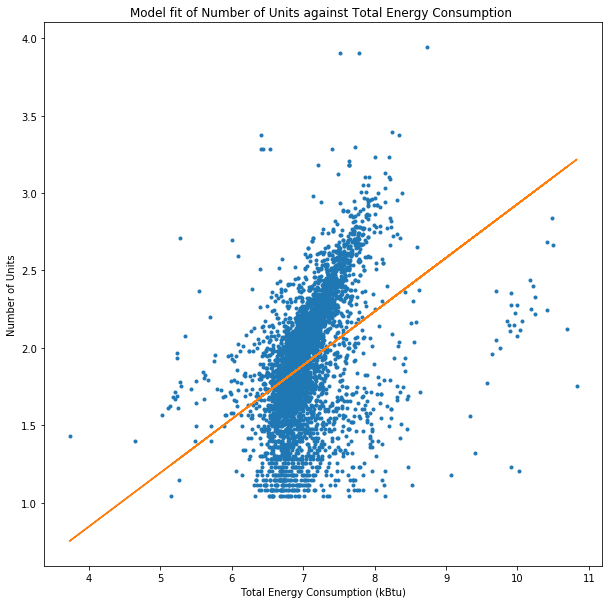

In [33]:
plt.figure(figsize=(10,10))

plt.plot( np.log10(bbljoincut['EnergyTotal']), 
         np.log10(bbljoincut['UnitsTotal']),'.')

plt.plot(np.log10(bbljoincut['EnergyTotal']), linmodel2.predict(sm.add_constant(np.log10(bbljoincut['EnergyTotal']))), '-')
plt.xlabel('Total Energy Consumption (kBtu)')
plt.ylabel('Number of Units')
plt.title('Model fit of Number of Units against Total Energy Consumption ')

### 3. Chi-Square

In [34]:
#Evaluate which is better by calculating the ChiSquare 
#Likelihood Ratio Test

model = linmodel.predict(sm.add_constant(np.log10(bbljoincut['UnitsTotal'])))
data = np.log10(bbljoincut['EnergyTotal'])
error = sqrt(data)
chisq = ((model - data)**2 / error)
chisq.sum()

305.05883630939041

In [35]:
model2 = linmodel2.predict(sm.add_constant(np.log10(bbljoincut['EnergyTotal'])))
data2 = np.log10(bbljoincut['UnitsTotal'])
error2 = sqrt(data2)
chisq2 = ((model2 - data2)**2 / error2)
chisq2.sum()

445.00426008562164

From the ChiSquare values, we can tell that the first model measuring Total Energy against Total Units has less errors

### 4. 2nd Degree Polynomial

In [36]:
#Fit a 2nd degree polynomial to the Units vs Energy
#statsmodels.formulae.api.ols()
df = pd.DataFrame()
df['x'] = np.log10(bbljoincut['UnitsTotal'])
df['x2'] = np.log10(bbljoincut['UnitsTotal'])**2
df['y'] = np.log10(bbljoincut['EnergyTotal'])
df.head()

x        x2         y
1   1.716003  2.944667  8.351449
4   1.633468  2.668219  6.507697
5   1.991226  3.964981  7.303210
9   1.176091  1.383191  7.633503
11  1.301030  1.692679  7.551926

In [37]:
#fitting a polynomial
poly = smf.ols('y ~ x + x2', data=df).fit()
poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     562.9
Date:                Mon, 04 Dec 2017   Prob (F-statistic):          9.94e-218
Time:                        12:24:52   Log-Likelihood:                -2508.8
No. Observations:                4280   AIC:                             5024.
Df Residuals:                    4277   BIC:                             5043.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.4228      0.103     71.935      0.000         7.220     7.625
x             -0.9196      0.106     -8.707      0.000        -1.127    -0.713
x2             0.3609      0.027     13.616      0.000         0.309     0.413
==============================================================================
Omnibus:                     2295.883   Durbin-Watson:                   1.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54127.403
Skew:                           2.061   Prob(JB):                         0.00
Kurtosis:                      19.927   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
dfpoly = np.arange(np.log10(bbljoincut['UnitsTotal']).min(),np.log10(bbljoincut['UnitsTotal']).max(), 0.1)
dfpoly = pd.DataFrame(dfpoly)
dfpoly.columns = ['x']
dfpoly['x2'] = dfpoly['x'] * dfpoly['x']
dfpoly.head()

x        x2
0  1.041393  1.084499
1  1.141393  1.302777
2  1.241393  1.541056
3  1.341393  1.799334
4  1.441393  2.077613

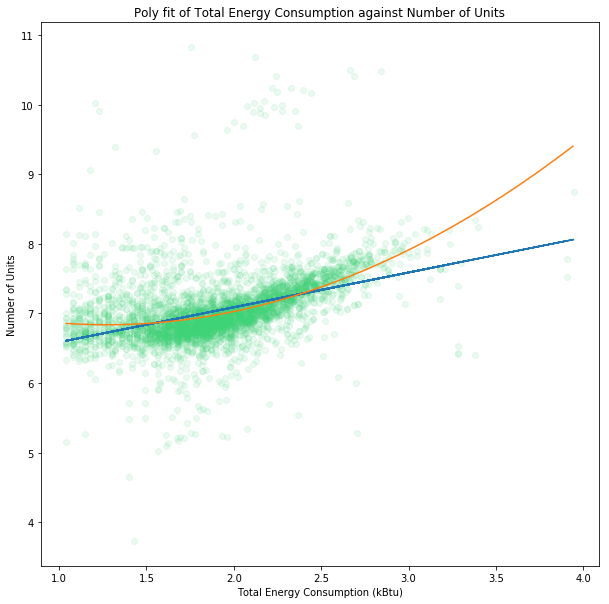

In [39]:
plt.figure(figsize=(10,10))
plt.plot(np.log10(bbljoincut['UnitsTotal']), np.log10(bbljoincut['EnergyTotal']), 'o', color='#3fd378', alpha=0.1)
plt.plot(np.log10(bbljoincut['UnitsTotal']), 
         linmodel.predict(sm.add_constant(np.log10(bbljoincut['UnitsTotal']))), '-')

pl.plot(dfpoly['x'], poly.predict(dfpoly, '-'))

plt.xlabel('Total Energy Consumption (kBtu)')
plt.ylabel('Number of Units')
plt.title('Poly fit of Total Energy Consumption against Number of Units')


### 5. Likelihood Ratio Test

Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test.

LR = -2 * (logLikelihood_Model1 - logLikelihood_Model2)

where Model1 is the least complex (fewer parameters).


In [40]:
linemodel = linmodel 
curvemodel = poly

print ("LR : ", -2 * (-linemodel.llf - (-curvemodel.llf)))
print ("LR from statsmodels:", curvemodel.compare_lr_test(linemodel))

LR :  -181.609106418
LR from statsmodels: (181.60910641783357, 2.1582191878856416e-41, 1.0)


Comparing the results to the ChiSquare table, at alpha = 0.05 and 1 Degree of Freedom, the Likelihood Ratio is statistically insignificant, therefore Model 2 is preferable to Model 1. 

Using table from: http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG

### 6. Conclusions: 

Our results shows that our model is only able to accurately predict 20% of the variation in energy consumed by a building given the number of units in the building. While both models have the same adjusted R-Squared value, the quadratic model is less errors, and hence will be a better model for predicting the relationship. 

Grade: 9/10 - explanation for error formulae missing.